# Predicting shop sales 

The data we are using gives us the sales for item and shop ID combinations over a period of about three years. Currently the data has no specific data structure but has many sales within these months. There are 34 months of sales data across 33 blocks - with each block being a month in consecutive order.

The purpose of this project is to use this data to make predictions for a set of shop/item ID combinations for the 34th block - or the following month (November) at the end of our set. Accordingly, we will need to prepare our data in a total sales per item/shop ID for each month/block.

First we will explore our data then perform some EDA. Once this has been completed we will cross validate with various models and attempt to make submissions with these models. Depending on out results we may go back and try different compilations of our training data as well as further feature engineering to see if we can optimize our submissions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in dataframes

sale_train = pd.read_csv('sales_train.csv')

sale_holdout = pd.read_csv('test.csv')

items = pd.read_csv('items.csv')

categories = pd.read_csv('categories.csv')

shops = pd.read_csv('shops.csv')



In [2]:
sale_holdout.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [3]:
sale_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [4]:
import datetime

sale_train['date'] = pd.to_datetime(sale_train['date'], format= '%d.%m.%Y')

sale_train['month'] = sale_train['date'].dt.month
sale_train['year'] = sale_train['date'].dt.year

sale_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,2013-01-02,0,59,22154,999.0,1.0,1,2013
1,2013-01-03,0,25,2552,899.0,1.0,1,2013
2,2013-01-05,0,25,2552,899.0,-1.0,1,2013


## Let's familiarise ourselves with the 'training' Data

Columns and Possible Variables:

In [5]:
print('--------COLUMN INFORMATION FOR PROVIDED DATA --------')
print('-----Sale_Train-----')
print(sale_train.columns)
print('-----items-----')
print(items.columns)
print('-----categories-----')
print(categories.columns)
print('-----shops-----')
print(shops.columns)

--------COLUMN INFORMATION FOR PROVIDED DATA --------
-----Sale_Train-----
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'month', 'year'],
      dtype='object')
-----items-----
Index(['item_id', 'category_id', 'item_name'], dtype='object')
-----categories-----
Index(['category_name', 'category_id'], dtype='object')
-----shops-----
Index(['shop_name', 'shop_id'], dtype='object')


In [6]:
print('--------INFORMATION AND D-TYPES--------')
print(sale_train.info())
print('--------NULL VALUES--------')
print(sale_train.isnull().sum())

--------INFORMATION AND D-TYPES--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
month             int64
year              int64
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 179.2 MB
None
--------NULL VALUES--------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
month             0
year              0
dtype: int64


As you can see there are no null values. So as things stand we do not have much cleaning to do on this dataframe. What is noticeable however is that the data-types our number data types  use a lot of memory (int64 and float64). In order to use less memory (which is important in this case as our database is quite large) we will downcast the datatype to use less memory.

In [7]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sale_train = downcast_dtypes(sale_train)

print(sale_train.info())

    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
date              datetime64[ns]
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
month             int16
year              int16
dtypes: datetime64[ns](1), float32(2), int16(5)
memory usage: 72.8 MB
None


As you can see we have more than halved the memory usage (going from 134.4 MB to 61.6 MB)

Let's merge our dataframes to make one single dataframe:

In [8]:
train = pd.merge(sale_train, items, on = 'item_id', how = 'left')

train = pd.merge(train, categories, on = 'category_id', how = 'left')

train = pd.merge(train, shops, on = 'shop_id', how = 'left')

train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
0,2013-01-02,0,59,22154,999.000000,1.0,1,2013,37,SCENE 2012 (BD),Cinema - Blu-Ray,"Yaroslavl TC"" Altair """
1,2013-01-03,0,25,2552,899.000000,1.0,1,2013,58,DEEP PURPLE The House Of Blue Light LP,Music - Vinyl,"Moscow TEC"" Atrium """
2,2013-01-05,0,25,2552,899.000000,-1.0,1,2013,58,DEEP PURPLE The House Of Blue Light LP,Music - Vinyl,"Moscow TEC"" Atrium """
3,2013-01-06,0,25,2554,1709.050049,1.0,1,2013,58,DEEP PURPLE Who Do You Think We Are LP,Music - Vinyl,"Moscow TEC"" Atrium """
4,2013-01-15,0,25,2555,1099.000000,1.0,1,2013,56,DEEP PURPLE 30 Very Best Of 2CD (Businesses).,Music - CD of corporate production,"Moscow TEC"" Atrium """
5,2013-01-10,0,25,2564,349.000000,1.0,1,2013,59,DEEP PURPLE Perihelion: Live In Concert DVD (C...,Music - Music video,"Moscow TEC"" Atrium """
6,2013-01-02,0,25,2565,549.000000,1.0,1,2013,56,DEEP PURPLE Stormbringer (firms).,Music - CD of corporate production,"Moscow TEC"" Atrium """
7,2013-01-04,0,25,2572,239.000000,1.0,1,2013,55,DEFTONES Koi No Yokan,Music - CD of local production,"Moscow TEC"" Atrium """
8,2013-01-11,0,25,2572,299.000000,1.0,1,2013,55,DEFTONES Koi No Yokan,Music - CD of local production,"Moscow TEC"" Atrium """
9,2013-01-03,0,25,2573,299.000000,3.0,1,2013,55,DEL REY LANA Born To Die,Music - CD of local production,"Moscow TEC"" Atrium """


# Checking for Outliers and Duplicates (General Data Cleaning)

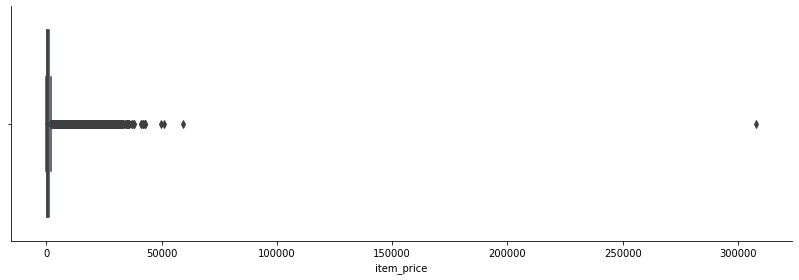

In [9]:
sns.catplot(x = 'item_price', kind = 'box', height = 4, aspect = 2.8, data = train)

In [10]:
over_the_top = train[train['item_price'] > 48000]

over_the_top

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
885138,2013-09-17,8,12,11365,59200.0,1.0,9,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
1163158,2013-12-13,11,12,6066,307980.0,1.0,12,2013,75,Radmin 3 - 522 people.,Programs - For home and office,Internet-shop of emergency situations
1488135,2014-03-20,14,25,13199,50999.0,1.0,3,2014,69,Collectible chess (Lord of the Rings),Gifts - Souvenirs,"Moscow TEC"" Atrium """
2327159,2015-01-29,24,12,7241,49782.0,1.0,1,2015,75,UserGate Proxy & Firewall 6.X with the module ...,Programs - For home and office,Internet-shop of emergency situations


## Outliers

Let's take a look at these outliers and see if they make sense, we can do this by seeing what the actual products are using the item_id:

- 11365
- 6066
- 13199
- 7241

## Item_id: 11365

In [11]:
train[train['item_id'] == 11365]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
58283,2013-01-09,0,12,11365,1148.000000,5.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58284,2013-01-10,0,12,11365,2235.000000,2.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58285,2013-01-14,0,12,11365,1753.333374,3.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58286,2013-01-15,0,12,11365,1435.000000,2.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58287,2013-01-16,0,12,11365,1930.000000,1.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58289,2013-01-17,0,12,11365,1115.000000,6.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58318,2013-01-21,0,12,11365,1600.000000,1.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58319,2013-01-24,0,12,11365,3170.000000,1.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58320,2013-01-25,0,12,11365,1620.000000,1.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations
58350,2013-01-28,0,12,11365,920.000000,1.0,1,2013,9,Shipping (EMS),Delivery of goods,Internet-shop of emergency situations


The category of the outlier is shipping. The amount of 307980.00 seems quite expensive for shipping. Let's see how it compares to other values in the dataset:

In [12]:
shipping_sales = train[train['item_id'] == 11365]

print('There are' , shipping_sales['item_price'].shape[0], 'instances of shipping.')
print()
print('Mean cost of shpping is:', shipping_sales['item_price'].mean())


There are 242 instances of shipping.

Mean cost of shpping is: 1887.565673828125


The mean for shipping costs is far below this outlier, and there are far too many instances of shipping for us to justify the hge value as an aggregation of shipping for many items. Although there are other significantly higher values for shippings item_cost, none are quite as high as 59,200.00. We will drop this row.   

## Item_id: 6066

In [13]:
train[train['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
1163158,2013-12-13,11,12,6066,307980.0,1.0,12,2013,75,Radmin 3 - 522 people.,Programs - For home and office,Internet-shop of emergency situations


The item_name for this outlier is 'Radmin 3 - 522 people'. A quick google search tells us that this is a progreamme for remote access. This google price also tells us that this is quite expensive for remote access tech. Although give the fact that it is purportedly for '522 people' it could be a reasonable entry. However, there is only once instance of this outlier so keeping it would most likely skew our model. We will drop it.

## Item_id: 13199

In [14]:
train[train['item_id'] == 13199]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
1488135,2014-03-20,14,25,13199,50999.0,1.0,3,2014,69,Collectible chess (Lord of the Rings),Gifts - Souvenirs,"Moscow TEC"" Atrium """


There is only one instance of this item - A collectible Lord Of The Ringsd Chess Set. It is not impossible that a collectors item like this could have such a large price - therefore it probably belongs in the dataset. However, seeing as it is so far out of line with the typical range of prices in our data, it might distort our predictions. Seeing as it is a solitary item we should be able to remove it without losing any predictive power in our model going forward.

## Item_id: 7241

In [15]:
train[train['item_id'] == 7241]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name
2327159,2015-01-29,24,12,7241,49782.0,1.0,1,2015,75,UserGate Proxy & Firewall 6.X with the module ...,Programs - For home and office,Internet-shop of emergency situations


Again, while this may be reasonably priced software, seeing as there is only one instance of it, and seeing that it is a significant outlier, we will drop it.

We will then **get rid of all prices over 48,000**, we will keep some extreme values below that to ensure that down the line our model will be able to generalize well on unseen data.

In [16]:
drop_index = train[train['item_price'] > 48000].index

train.drop(drop_index, inplace = True)

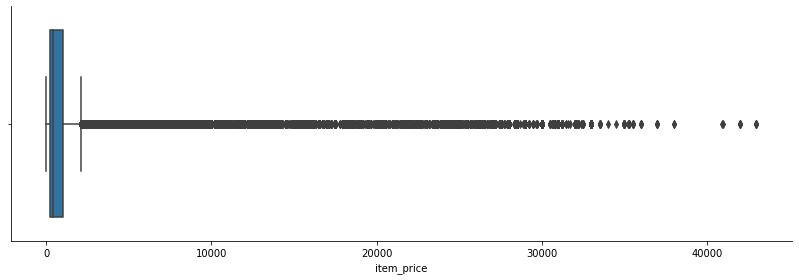

In [17]:
sns.catplot(x = 'item_price', kind = 'box', height = 4, aspect = 2.8, data = train)

let's make sure none of the single-instance items we are dropping are in the given test set:

In [18]:
item_ids = [6066,3199,7241]

for i in item_ids:
    print(sale_holdout[sale_holdout['item_id'] == i])



Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []
Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []
Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []


# Preperation - Item/Category Information

In [19]:
len(train['category_name'].unique())

84

While it seems that there are multitudes of unique values for category names, what is apparent is that almost all the categories have a main category, followed by a dash which is then followed by a subcategory (eg: 'Accessories - XBOX').

What we will do then is extract the first string or word in each category name in order to create a new column which holds the general category. In doing so we can make a more simplified feature with less variance (in contrast to each product having it's own unique category) that should be more optimal for a preditive model.

In [20]:
train['general_cat'] = train['category_name'].str.extract(r'(^[\w\s]*)')

train['general_cat'] = train['general_cat'].str.strip()

train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,category_id,item_name,category_name,shop_name,general_cat
0,2013-01-02,0,59,22154,999.000000,1.0,1,2013,37,SCENE 2012 (BD),Cinema - Blu-Ray,"Yaroslavl TC"" Altair """,Cinema
1,2013-01-03,0,25,2552,899.000000,1.0,1,2013,58,DEEP PURPLE The House Of Blue Light LP,Music - Vinyl,"Moscow TEC"" Atrium """,Music
2,2013-01-05,0,25,2552,899.000000,-1.0,1,2013,58,DEEP PURPLE The House Of Blue Light LP,Music - Vinyl,"Moscow TEC"" Atrium """,Music
3,2013-01-06,0,25,2554,1709.050049,1.0,1,2013,58,DEEP PURPLE Who Do You Think We Are LP,Music - Vinyl,"Moscow TEC"" Atrium """,Music
4,2013-01-15,0,25,2555,1099.000000,1.0,1,2013,56,DEEP PURPLE 30 Very Best Of 2CD (Businesses).,Music - CD of corporate production,"Moscow TEC"" Atrium """,Music


In [21]:
len(train['general_cat'].unique())

19

As you can see we have removed some of the variance in our data by using general categories to describe products - we now have 19 categories vs the original 84. This should go a long way in getting more insight out of our product data.
We can now drop the following columns we won't be needing for the time being: 

- 'category_id' 
- 'category_name'
- 'item_name'
- 'date'

In [22]:
train.drop(['item_name', 'category_id', 'category_name', 'date'], axis = 1, inplace = True)

train['total_price'] = train['item_price'] * train['item_cnt_day']

train.head(5)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price
0,0,59,22154,999.000000,1.0,1,2013,"Yaroslavl TC"" Altair """,Cinema,999.000000
1,0,25,2552,899.000000,1.0,1,2013,"Moscow TEC"" Atrium """,Music,899.000000
2,0,25,2552,899.000000,-1.0,1,2013,"Moscow TEC"" Atrium """,Music,-899.000000
3,0,25,2554,1709.050049,1.0,1,2013,"Moscow TEC"" Atrium """,Music,1709.050049
4,0,25,2555,1099.000000,1.0,1,2013,"Moscow TEC"" Atrium """,Music,1099.000000


# Further EDA

Now that our dataset is in a form we can work with, we can do further EDA to get an idea of what is happening in our data - which in turn should give us some direction in terms of feature engineering.

## Sales By Month and Year

In [23]:
monthly = train.groupby(['month', 'year'], as_index = False)['item_cnt_day'].sum()

monthly.head(5)

,month,year,item_cnt_day
0,1,2013,131479.0
1,1,2014,116899.0
2,1,2015,110970.0
3,2,2013,128090.0
4,2,2014,109687.0


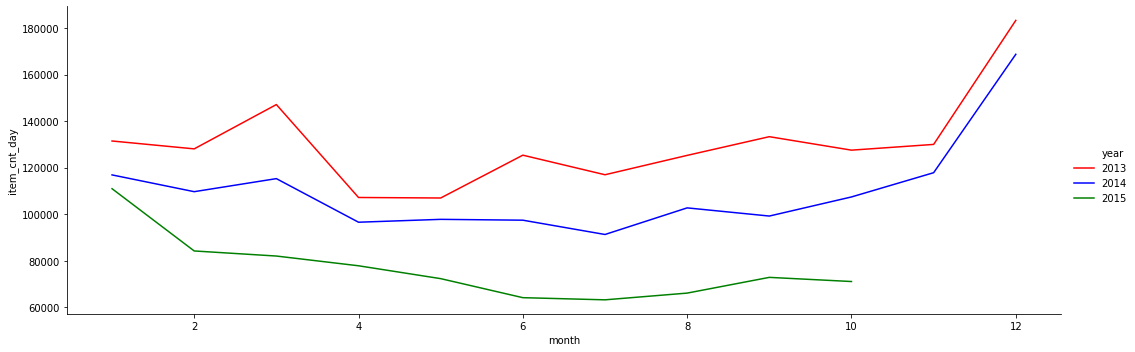

In [24]:
sns.relplot(x = 'month', y = 'item_cnt_day', hue = 'year',
            data = monthly, kind = 'line', height = 5, aspect = 3,
           palette = ['red', 'blue', 'green'])

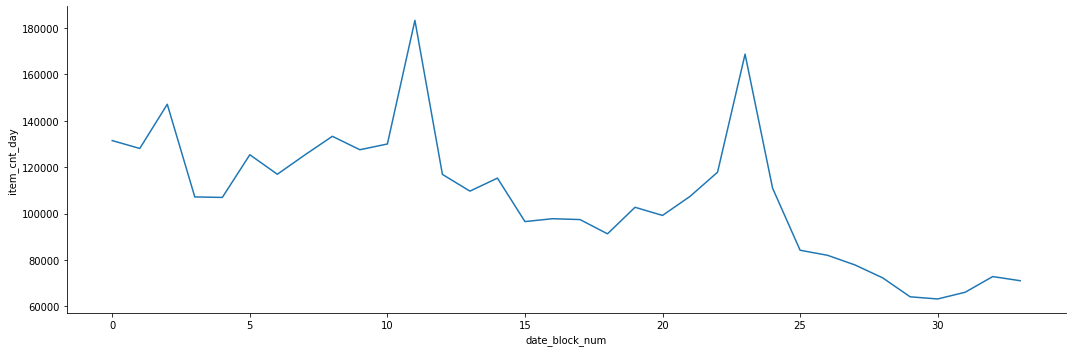

In [25]:
by_block = train.groupby(['date_block_num'], as_index = False)['item_cnt_day'].sum()

sns.relplot(x = 'date_block_num', y = 'item_cnt_day', data = by_block, kind = 'line',
           aspect = 3, height = 5)

When looking at this graph it would seem as if monthly sales are decreasing year on year - getting worse every year. This is also evidenced by the downward trend seen in the graph of 'item_cnt_day' per date_block_num (month count). This tells us that to capoture this information it would be good to use some manner of 'rolling' function to account for the trend movement when makming predictions. What is also obvious here (especially in 20123 and 2014) is that there is a distinguishable degree of seasonality across the months that we must account for!

Also, as is evidenced by the graph above, our 'item_cnt_day' is trending downwards - this means that we should consider using an ARIMA model to account for the trend (in order to achieve stationarity).

In [26]:
t_sales_per_cat = train.groupby(['general_cat'], as_index = False)['item_cnt_day'].sum()

t_sales_per_cat.head(3)

,general_cat,item_cnt_day
0,Accessories,85056.0
1,Android games,114.0
2,Batteries,12032.0


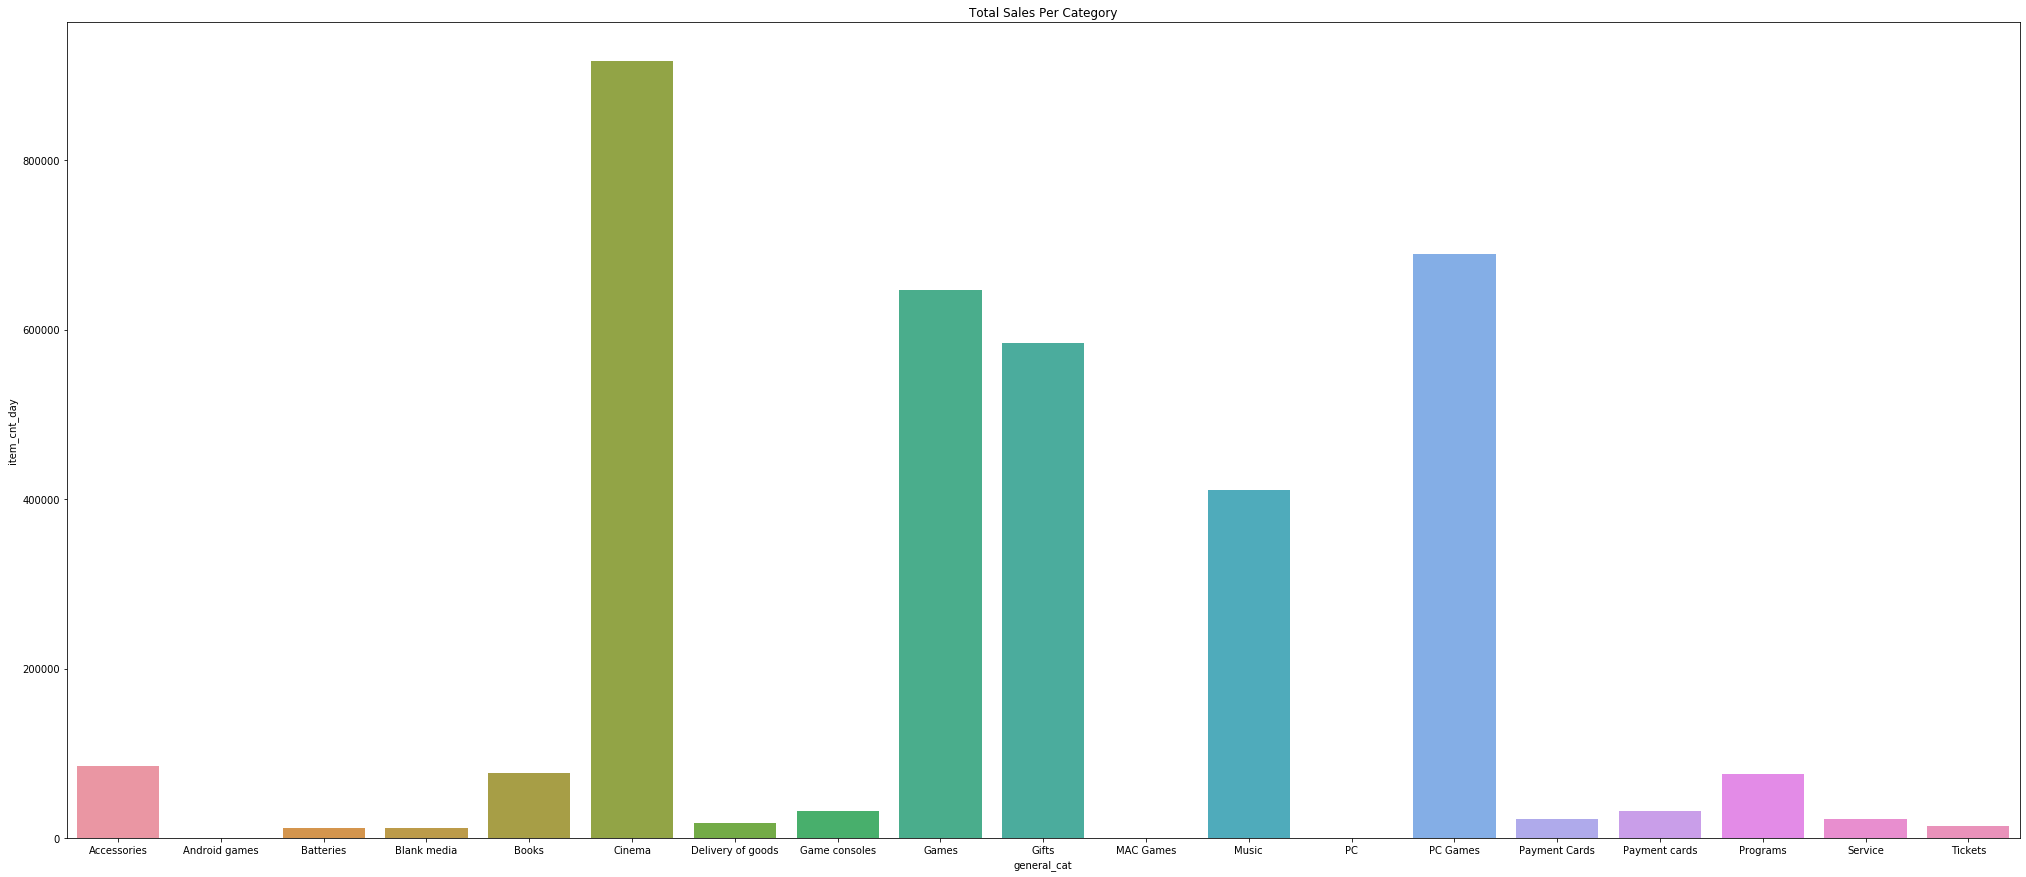

In [27]:
plt.figure(figsize = (35,15))
plt.title('Total Sales Per Category')

sns.barplot(x = 'general_cat', y = 'item_cnt_day', data = t_sales_per_cat)


In [28]:
average_price = train.groupby(['month', 'year'], as_index = False)['item_price'].mean()


average_price.head(3)

,month,year,item_price
0,1,2013,710.622131
1,1,2014,862.869141
2,1,2015,1135.592896


Text(0.5, 0.98, 'Average Price Per Month By Year')

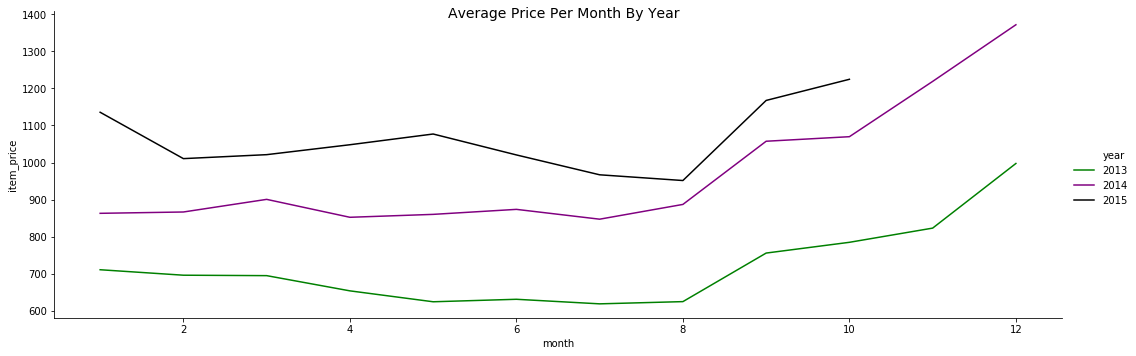

In [29]:
ap = sns.relplot(x = 'month', y= 'item_price', hue = 'year',data = average_price,
            kind = 'line', height = 5, aspect = 3, palette = ['green', 'purple', 'black'])

ap.fig.suptitle('Average Price Per Month By Year', fontsize = 14)

We can see that over time prices have increased year on year - this would be expected given inflation and such. An observation we can make is that the aggregate price increase year oin year between 2014 and 2015 is smaller than the aggregate year on year price increase between 2013 and 2014. Again we can see that there is seasonality and trend in the average price month on month.

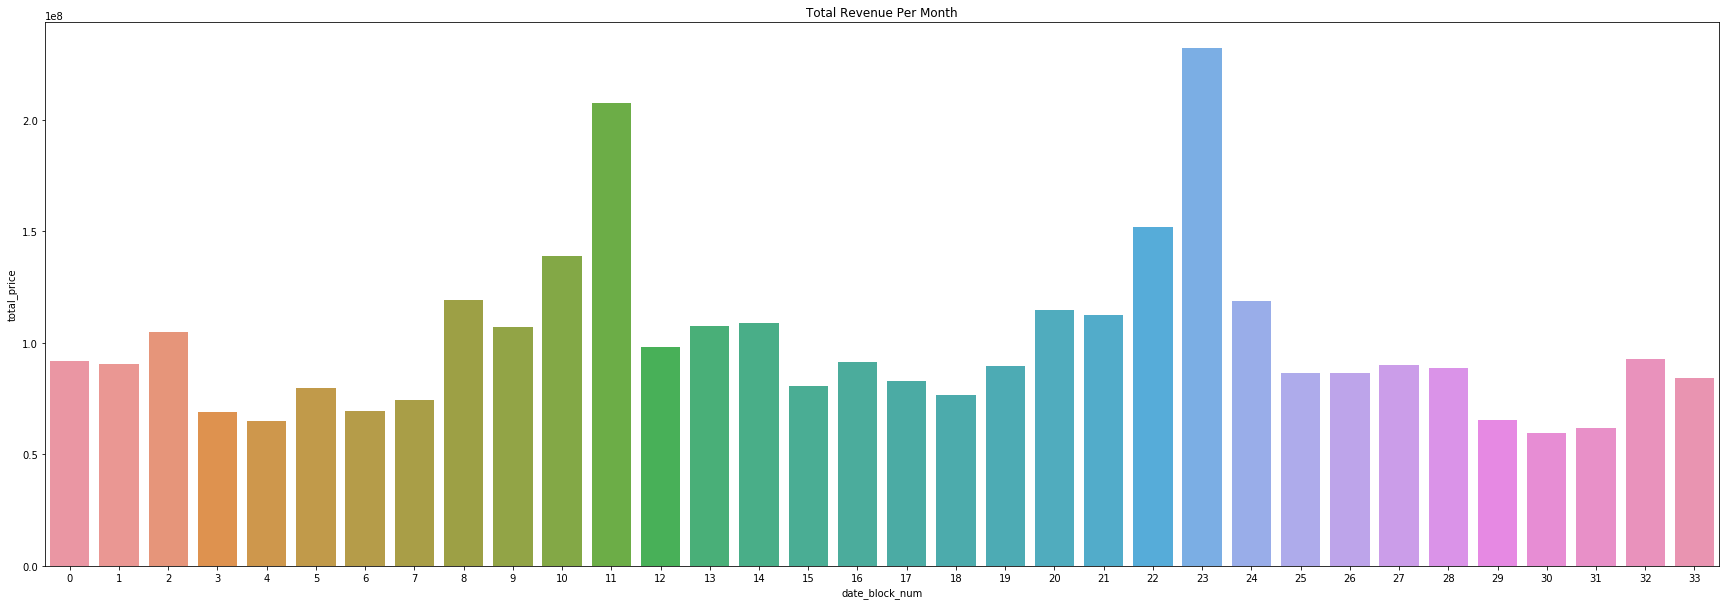

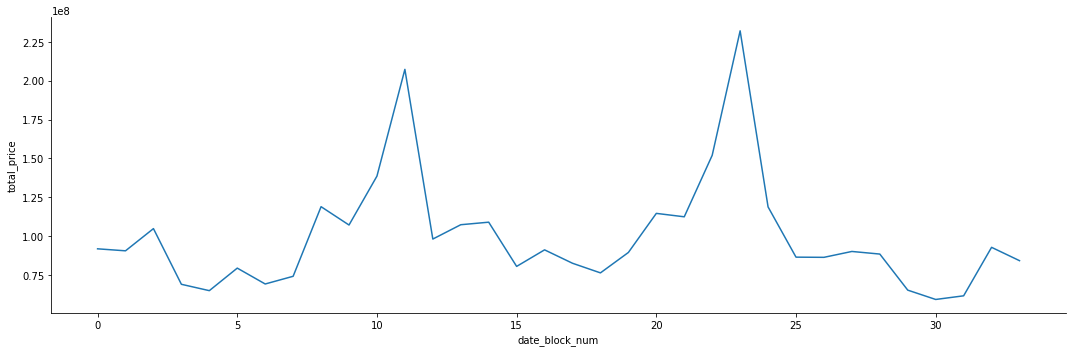

In [30]:
price_agg_month = train.groupby(['date_block_num'], as_index = False)['total_price'].sum()

plt.figure(figsize = (30,10))
plt.title('Total Revenue Per Month')


sns.barplot(x= 'date_block_num', y= 'total_price', data = price_agg_month,
            order = price_agg_month['date_block_num']);


sns.relplot(x = 'date_block_num', y = 'total_price', data = price_agg_month, kind = 'line',
           height = 5, aspect = 3)


Looking at the total revenue over the 33 block time period we can again see clear evidence of both seasonality and trend. It must be noted that other charts have shown us that the quantity of items sold has decreased over the 33 month period of our training data. When looking at this revenue chart however, it seems that total revenue is trending slightly upwards - seeing as we know that volume is trending the other way, it should be evident that the that this is explained by the increase in price year on year.

# Feature Engineering

Let's take a look at the rolling mean over a year as well as the rolling standard deviations:

In [31]:
sales_by_block = train.groupby(['date_block_num'], as_index = True)['item_cnt_day'].sum()

sales_by_block.head(3)

date_block_num
0    131479.0
1    128090.0
2    147142.0
Name: item_cnt_day, dtype: float32

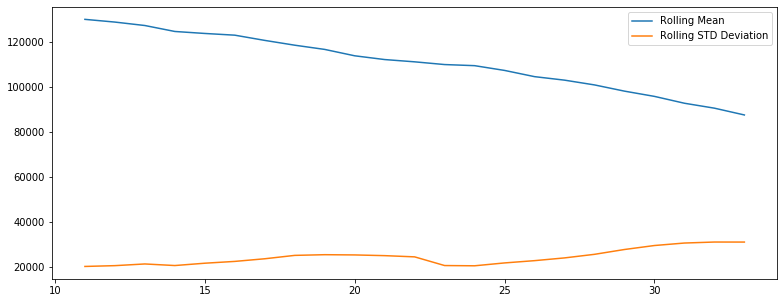

In [32]:
plt.figure(figsize = (13,5))
plt.plot(sales_by_block.rolling(window = 12).mean(), label = 'Rolling Mean')
plt.plot(sales_by_block.rolling(window = 12).std(), label = 'Rolling STD Deviation')
plt.legend()

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


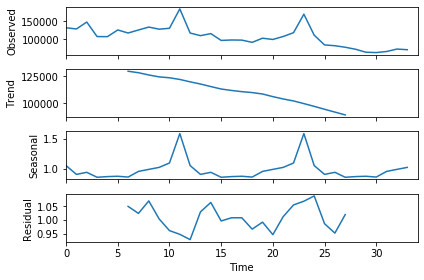

In [33]:
import statsmodels.api as sm

## Multplicative

res = sm.tsa.seasonal_decompose(sales_by_block.values, freq = 12, model = "multiplicative")

fig = res.plot()

fig.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


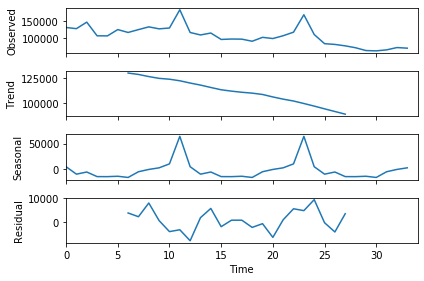

In [34]:
## Additive
res = sm.tsa.seasonal_decompose(sales_by_block.values, freq = 12, model = 'additive')
fig = res.plot()

fig.show()


Above we can see that there is clear and formal evidence of trend and seasonality. 

We therefore need a way to include these aspects of the data in our features. We need features that are reflective of the trend and the seasonality aapprent in the data.

# Data Set-up

We need to get the data in the correct format to model, test and make our submissions. Seeing as we have the test_set, we know which item-shop combinations we need to make predictions for. The first step then would be to determine what, if any, shops and or items are in the test set but not in the training set. It would seem obvious that there may be new products (items) that are introduced at many junctures in our data. We need to find a way to make an attempt at modelling these items - even if there may not be much available data to work with.

In [35]:
train_items = list(train['item_id'].unique())

test_items = list(sale_holdout['item_id'].unique())

unaligned_items = []

for item in test_items:
    if item in train_items:
        pass
    else:
        unaligned_items.append(item)
        
    

In [36]:
print('Items that appear in test data, but not training data:', len(unaligned_items))

Items that appear in test data, but not training data: 363


In [37]:
train_shops = list(train['shop_id'].unique())

test_items = list(sale_holdout['shop_id'].unique())

unaligned_shops = []

for shop in test_items:
    if shop in train_items:
        pass
    else:
        unaligned_shops.append(item)

In [38]:
print('Shops that appear in test data, but not training data:', len(unaligned_shops))

Shops that appear in test data, but not training data: 0


We now know that all the shops that appear in our test_data also appear in our training data. However, we now also know that there are items that are appear in our test data, but that we have no prior data for in our training data. Right now the best thing we can do is assign each of these items their correct respective categories.

In [39]:
categories['general_cat'] = categories['category_name'].str.extract(r'(^[\w\s]*)')

categories.head()

,category_name,category_id,general_cat
0,PC - Headsets / Headphones,0,PC
1,Accessories - PS2,1,Accessories
2,Accessories - PS3,2,Accessories
3,Accessories - PS4,3,Accessories
4,Accessories - PSP,4,Accessories


In [40]:
mapping_dict = pd.Series(categories['general_cat'].values, index = categories['category_id']).to_dict()

mapping_dict

{0: 'PC ',
 1: ' Accessories ',
 2: ' Accessories ',
 3: ' Accessories ',
 4: ' Accessories ',
 5: ' Accessories ',
 6: ' Accessories ',
 7: ' Accessories ',
 8: ' Tickets ',
 9: ' Delivery of goods',
 10: ' Game consoles ',
 11: ' Game consoles ',
 12: ' Game consoles ',
 13: ' Game consoles ',
 14: ' Game consoles ',
 15: ' Game consoles ',
 16: ' Game consoles ',
 17: ' Game consoles ',
 18: ' Games ',
 19: ' Games ',
 20: ' Games ',
 21: ' Games ',
 22: ' Games ',
 23: ' Games ',
 24: ' Games ',
 25: ' Games ',
 26: ' Android games ',
 27: ' MAC Games ',
 28: ' PC Games ',
 29: ' PC Games ',
 30: ' PC Games ',
 31: ' PC Games ',
 32: ' Payment Cards ',
 33: ' Payment Cards ',
 34: ' Payment Cards ',
 35: ' Payment cards ',
 36: ' Payment cards ',
 37: ' Cinema ',
 38: ' Cinema ',
 39: ' Cinema ',
 40: ' Cinema ',
 41: ' Cinema ',
 42: ' Books ',
 43: ' Books ',
 44: ' Books ',
 45: ' Books ',
 46: ' Books ',
 47: ' Books ',
 48: ' Books ',
 49: ' Books ',
 50: ' Books ',
 51: ' Boo

In [41]:
items['general_cat'] = items['category_id'].map(mapping_dict)

items.head()

,item_id,category_id,item_name,general_cat
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D,Cinema
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...,Programs
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D,Cinema
3,3,40,*** BLUE WAVE (Univ) D,Cinema
4,4,40,*** BOX (GLASS) D,Cinema


In [42]:
mapping_dict_cats = pd.Series(items['general_cat'].values, index = items['item_id']).to_dict()

In [43]:
train['ID'] = list(zip(train['shop_id'], train['item_id']))

holdout_sales = sale_holdout.copy()

holdout_sales['ID'] = list(zip(holdout_sales['shop_id'], holdout_sales['item_id']))

In [44]:
train.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price,ID
0,0,59,22154,999.0,1.0,1,2013,"Yaroslavl TC"" Altair """,Cinema,999.0,"(59, 22154)"
1,0,25,2552,899.0,1.0,1,2013,"Moscow TEC"" Atrium """,Music,899.0,"(25, 2552)"
2,0,25,2552,899.0,-1.0,1,2013,"Moscow TEC"" Atrium """,Music,-899.0,"(25, 2552)"


In [45]:
holdout_sales.head(3)

,ID,shop_id,item_id
0,"(5, 5037)",5,5037
1,"(5, 5320)",5,5320
2,"(5, 5233)",5,5233


In [46]:
all_data = pd.merge(holdout_sales, train, on = 'ID', how = 'left')

all_data.head(25)

,ID,shop_id_x,item_id_x,date_block_num,shop_id_y,item_id_y,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price
0,"(5, 5037)",5,5037,20.0,5.0,5037.0,2599.0,1.0,9.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0
1,"(5, 5037)",5,5037,22.0,5.0,5037.0,2599.0,1.0,11.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0
2,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0
3,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0
4,"(5, 5037)",5,5037,24.0,5.0,5037.0,1999.0,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0
5,"(5, 5037)",5,5037,24.0,5.0,5037.0,1999.0,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0
6,"(5, 5037)",5,5037,28.0,5.0,5037.0,1299.0,1.0,5.0,2015.0,"Vologda SEC ""Marmelad""",Games,1299.0
7,"(5, 5037)",5,5037,29.0,5.0,5037.0,1499.0,1.0,6.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0
8,"(5, 5037)",5,5037,30.0,5.0,5037.0,1499.0,1.0,7.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0
9,"(5, 5037)",5,5037,31.0,5.0,5037.0,1499.0,1.0,8.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0


In [47]:
all_data.drop(['shop_id_y', 'item_id_y'], axis = 1)

mapping_dict_shops = pd.Series(train['shop_name'].values, index = train['shop_id']).to_dict()

In [48]:
all_data.head(30)

,ID,shop_id_x,item_id_x,date_block_num,shop_id_y,item_id_y,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price
0,"(5, 5037)",5,5037,20.0,5.0,5037.0,2599.0,1.0,9.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0
1,"(5, 5037)",5,5037,22.0,5.0,5037.0,2599.0,1.0,11.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0
2,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0
3,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0
4,"(5, 5037)",5,5037,24.0,5.0,5037.0,1999.0,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0
5,"(5, 5037)",5,5037,24.0,5.0,5037.0,1999.0,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0
6,"(5, 5037)",5,5037,28.0,5.0,5037.0,1299.0,1.0,5.0,2015.0,"Vologda SEC ""Marmelad""",Games,1299.0
7,"(5, 5037)",5,5037,29.0,5.0,5037.0,1499.0,1.0,6.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0
8,"(5, 5037)",5,5037,30.0,5.0,5037.0,1499.0,1.0,7.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0
9,"(5, 5037)",5,5037,31.0,5.0,5037.0,1499.0,1.0,8.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0


Thus far we have dropped the duplicate columns remaining after our merging of the train and test data. We have also created mapping dictionaries of shop names and corresponding shop_id's as well as of item_id's and corresponding general categories. We can now populate NaN values for items that were in the test set but not in the training set. In doing so we can impute their general category as well as their shops names, with the hope of possibly using this information to help us make some prediction of their expected total sales for the month of November.

In [49]:
all_data['shop_name'] = all_data['shop_id_x'].map(mapping_dict_shops)
all_data['general_cat'] = all_data['item_id_x'].map(mapping_dict_cats)


In [50]:
shops['shop_id'].nunique()

60

There appear to be sixty unique shops. Maybe we can further rationalise our predictions for new items in the sale set by determining if there is any correlation to the Shops and the average price of a product. If we can find this averager price we can fill the NAN values with it which should go someway to determining future sales for November.

In [51]:
average_price_shop = train.groupby(['shop_id'])['total_price'].mean()

mapping_dict_price_shop = average_price_shop.to_dict()

average_price_shop_df = pd.DataFrame(average_price_shop).reset_index()

average_price_shop_df.head(3)

,shop_id,total_price
0,0,673.366150
1,1,570.307678
2,2,1694.803589


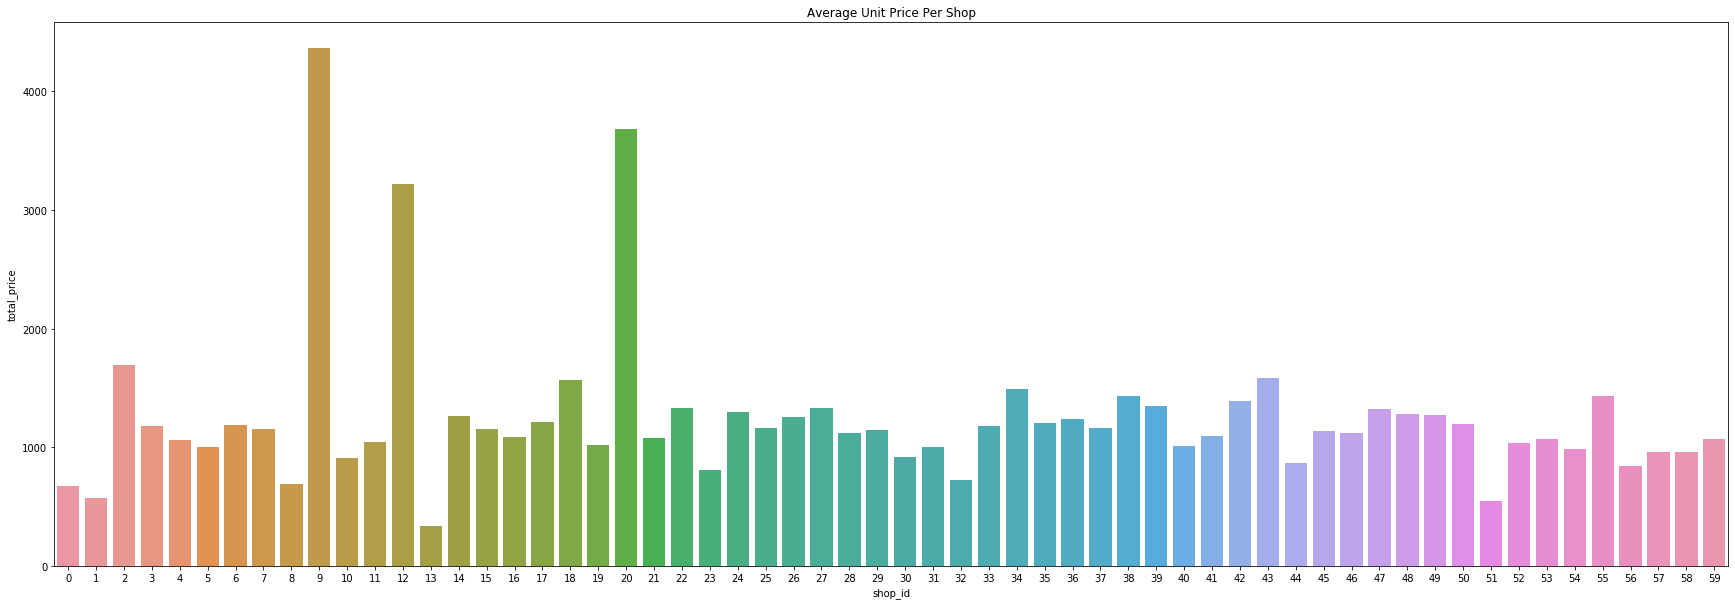

In [52]:
plt.figure(figsize = (30,10))
plt.title('Average Unit Price Per Shop')

sns.barplot(x= 'shop_id', y= 'total_price', data = average_price_shop_df,
            order = average_price_shop_df['shop_id'])

Let's now fill the NaN values in the 'item_price' column, for all new items in test data that is not in train data. We will use the average unit price per shop to fill these values:

In [53]:
all_data['item_price'] = all_data['item_price'].fillna(all_data['shop_id_x'].map(mapping_dict_price_shop))

In [54]:
def price_bins(df):
    cut_points = [0, 800, 1600, 2400, 3200, 4000, 6000]
    label_names = ['cheapest', 'cheap', 'pricier', 'expensive', 'very_expensive', 'most_expensive']
    df['price_cat'] = pd.cut(df['item_price'], cut_points, labels = label_names)
    return df

price_bins(all_data)

all_data.rename(columns = {'shop_id_x': 'shop_id', 'item_id_x': 'item_id'}, inplace = True)

all_data.head(3)


,ID,shop_id,item_id,date_block_num,shop_id_y,item_id_y,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price,price_cat
0,"(5, 5037)",5,5037,20.0,5.0,5037.0,2599.0,1.0,9.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
1,"(5, 5037)",5,5037,22.0,5.0,5037.0,2599.0,1.0,11.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
2,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier


We have created a categorical column for the item_price in the hopes that it will lend these feature more predictive power. Once we have our final data organized we will one-hot encode both the 'price_cat' and 'general_cat' cols by creating dummy variables. We will also be dropping redundant columns.

We will need to create lags to account for seasonality as well as trend over the time period of our data. On top of this it is essential that our lags go some way in highlighting the addition of new products and the resultant sales amounts ascribed on average to new items - if we are hoping to get concrete predictions for the new items in the test set.

Once we have created our lags, the next step now is to group the data by 'date_block_num', including all the cols we will be using as features for our training and testing.

We will then need to split the data into test and train - deciding on the structure of these data sets will be important for our predictions

In [55]:
## Create Mappig dict for price categories

mapping_dict_price_cats = pd.Series(all_data['price_cat'].values, index = all_data['shop_id']).to_dict()

In [56]:
all_data.shape

(1327234, 14)

In [57]:
all_data.head()

,ID,shop_id,item_id,date_block_num,shop_id_y,item_id_y,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price,price_cat
0,"(5, 5037)",5,5037,20.0,5.0,5037.0,2599.0,1.0,9.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
1,"(5, 5037)",5,5037,22.0,5.0,5037.0,2599.0,1.0,11.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
2,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
3,"(5, 5037)",5,5037,23.0,5.0,5037.0,1999.0,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
4,"(5, 5037)",5,5037,24.0,5.0,5037.0,1999.0,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier


In [58]:
holdout_sales.head(3)

,ID,shop_id,item_id
0,"(5, 5037)",5,5037
1,"(5, 5320)",5,5320
2,"(5, 5233)",5,5233


In [59]:
holdout_sales.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [60]:
all_data['ID'].nunique()

214200

We now know that our 'all_data' dataframe has all the item and shop combinations as they appear in the training data.

In [61]:
all_data['item_cnt_day'].fillna(value = 0, inplace = True)
all_data['date_block_num'].fillna(value = 34, inplace = True)
all_data['date_block_num'] = all_data['date_block_num'].astype('int')

all_data.head(15)


,ID,shop_id,item_id,date_block_num,shop_id_y,item_id_y,item_price,item_cnt_day,month,year,shop_name,general_cat,total_price,price_cat
0,"(5, 5037)",5,5037,20,5.0,5037.0,2599.000000,1.0,9.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
1,"(5, 5037)",5,5037,22,5.0,5037.0,2599.000000,1.0,11.0,2014.0,"Vologda SEC ""Marmelad""",Games,2599.0,expensive
2,"(5, 5037)",5,5037,23,5.0,5037.0,1999.000000,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
3,"(5, 5037)",5,5037,23,5.0,5037.0,1999.000000,1.0,12.0,2014.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
4,"(5, 5037)",5,5037,24,5.0,5037.0,1999.000000,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
5,"(5, 5037)",5,5037,24,5.0,5037.0,1999.000000,1.0,1.0,2015.0,"Vologda SEC ""Marmelad""",Games,1999.0,pricier
6,"(5, 5037)",5,5037,28,5.0,5037.0,1299.000000,1.0,5.0,2015.0,"Vologda SEC ""Marmelad""",Games,1299.0,cheap
7,"(5, 5037)",5,5037,29,5.0,5037.0,1499.000000,1.0,6.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0,cheap
8,"(5, 5037)",5,5037,30,5.0,5037.0,1499.000000,1.0,7.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0,cheap
9,"(5, 5037)",5,5037,31,5.0,5037.0,1499.000000,1.0,8.0,2015.0,"Vologda SEC ""Marmelad""",Games,1499.0,cheap


In [62]:
monthly_sales = all_data.pivot_table(index = ['ID'], values = ['item_cnt_day'], 
                                     columns = ['date_block_num'],
                                     aggfunc = np.sum, fill_value = 0, dropna = False).reset_index()

## Unable to use more cols for index - runtime infinite on jupyter. Will need another solution

monthly_sales.columns = monthly_sales.columns.droplevel().map(str)

monthly_sales = monthly_sales.reset_index(drop = True).rename_axis(None, axis = 1)

monthly_sales.columns.values[0] = 'ID'

monthly_sales.head()

,ID,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,"(2, 30)",0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(2, 31)",0,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,"(2, 32)",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,"(2, 33)",1,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,0,0
4,"(2, 38)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
## We need to add item_id and shop_id to the monthly_sales DF so we can use it to
## infer categorical values for 'general_cat' and 'price_cat'

monthly_sales[['shop_id', 'item_id']] = pd.DataFrame(monthly_sales['ID'].tolist(), index= monthly_sales.index)  

monthly_sales['general_cat'] = monthly_sales['item_id'].map(mapping_dict_cats)

monthly_sales['price_cat'] = monthly_sales['shop_id'].map(mapping_dict_price_cats)

monthly_sales.head()

,ID,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,shop_id,item_id,general_cat,price_cat
0,"(2, 30)",0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,2,30,Cinema,pricier
1,"(2, 31)",0,4,1,1,0,0,0,0,0,...,0,0,0,0,1,0,2,31,Cinema,pricier
2,"(2, 32)",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,32,Cinema,pricier
3,"(2, 33)",1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,2,33,Cinema,pricier
4,"(2, 38)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,38,Cinema,pricier


In [64]:
## Moving categorical cols to the beginning of the dataset

block_num_cols = list(range(0,35))
block_num_cols = list(map(str, block_num_cols))

monthly_sales = monthly_sales[[c for c in monthly_sales.columns if c not in block_num_cols] + block_num_cols]

monthly_sales.drop(columns = ['item_id', 'shop_id'], inplace = True)

monthly_sales.set_index('ID', inplace = True)

monthly_sales.head(5)

,general_cat,price_cat,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
ID,,,,,,,,,,,,,,,,,,,,,
"(2, 30)",Cinema,pricier,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2, 31)",Cinema,pricier,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"(2, 32)",Cinema,pricier,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
"(2, 33)",Cinema,pricier,1,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,0,0
"(2, 38)",Cinema,pricier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
## Re-sorting index so that it matches the order of the test_csv submission file for the competition

monthly_sales = pd.DataFrame(monthly_sales.reindex(list(all_data['ID'].unique())))

monthly_sales.head()

,general_cat,price_cat,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",Games,cheapest,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,3,1,0,0
"(5, 5320)",Music,cheapest,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(5, 5233)",Games,cheapest,0,0,0,0,0,0,0,0,...,0,0,0,3,2,0,1,3,1,0
"(5, 5232)",Games,cheapest,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
"(5, 5268)",Games,cheapest,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Further Feature Engineering

Our data is beginning to look like it nearly ready for training. Right now we have the respective total item sales per each month/block in the entire timeframe for each combination (as it appears in thge test data) item and shop.

Right now we want to find ways to account for the trend and seasonality in our data - we will need to do this by creating some lags. We will use lags of the same month from the previous year across each block to account for trend over the course of our data's timeline. In order to account for both new products as well as seasonility, we will use a lag for the previous month/block of each month/block. Ultimately this means we will be dropping the entire first year of our data. 

The plan is really to train our model using the first 10 months of the second year as train_features, with our train_target being the total item sales for each shop_item combination for the 11th Month or for November of that year.

We will then use this model to predict November of the following year (block 34), based on the first ten months for the final year, or bloack 23 through 33.

We will also be one-hot-encoding our categorical features ('general_cat' & 'price_cat') by creating dummies.

In [66]:
## Lagged values from the previous month

previous_month = monthly_sales.shift(1, axis = 1)

previous_month.drop(['general_cat', 'price_cat'], axis = 1, inplace = True)

previous_month.columns = [str(col) + ' p_month' for col in previous_month.columns]

previous_month.head(3)



,0 p_month,1 p_month,2 p_month,3 p_month,4 p_month,5 p_month,6 p_month,7 p_month,8 p_month,9 p_month,...,25 p_month,26 p_month,27 p_month,28 p_month,29 p_month,30 p_month,31 p_month,32 p_month,33 p_month,34 p_month
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
"(5, 5320)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 5233)",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0


In [67]:
## Lagged values from the same month in the previous year

last_year = monthly_sales.shift(12, axis =1)
last_year.drop(['general_cat', 'price_cat'], inplace = True, axis = 1)
last_year.columns = [str(col) + ' last_year' for col in last_year.columns]
last_year.iloc[:, 10:26].head(3)


,10 last_year,11 last_year,12 last_year,13 last_year,14 last_year,15 last_year,16 last_year,17 last_year,18 last_year,19 last_year,20 last_year,21 last_year,22 last_year,23 last_year,24 last_year,25 last_year
ID,,,,,,,,,,,,,,,,
"(5, 5037)",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 5320)",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(5, 5233)",NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In implementing lagged values for prior periods, for instances where there is no informaiton for the prior periods (1 month or 12 month lag) NaN values will be returned.

In [68]:
## alm = all_monthly_data

alm = pd.concat([monthly_sales, previous_month, last_year], axis = 1)

cols = ['general_cat'] + ['price_cat'] + sorted(alm.columns[2:], key = lambda x: int(x.split(" ")[0]))

alm = alm[cols]

alm.head(5)

,general_cat,price_cat,0,0 p_month,0 last_year,1,1 p_month,1 last_year,2,2 p_month,...,31 last_year,32,32 p_month,32 last_year,33,33 p_month,33 last_year,34,34 p_month,34 last_year
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",Games,cheapest,0,NaN,NaN,0,0.0,NaN,0,0.0,...,0.0,1,3.0,1.0,0,1.0,0.0,0,0.0,1.0
"(5, 5320)",Music,cheapest,0,NaN,NaN,0,0.0,NaN,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
"(5, 5233)",Games,cheapest,0,NaN,NaN,0,0.0,NaN,0,0.0,...,0.0,3,1.0,0.0,1,3.0,0.0,0,1.0,0.0
"(5, 5232)",Games,cheapest,0,NaN,NaN,0,0.0,NaN,0,0.0,...,0.0,0,1.0,0.0,0,0.0,0.0,0,0.0,0.0
"(5, 5268)",Games,cheapest,0,NaN,NaN,0,0.0,NaN,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [69]:
cols_to_drop = alm.iloc[:, 2:38].columns

alm.drop(cols_to_drop, axis = 1, inplace = True)

alm.head(3)


,general_cat,price_cat,12,12 p_month,12 last_year,13,13 p_month,13 last_year,14,14 p_month,...,31 last_year,32,32 p_month,32 last_year,33,33 p_month,33 last_year,34,34 p_month,34 last_year
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",Games,cheapest,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0.0,1,3.0,1.0,0,1.0,0.0,0,0.0,1.0
"(5, 5320)",Music,cheapest,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
"(5, 5233)",Games,cheapest,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0.0,3,1.0,0.0,1,3.0,0.0,0,1.0,0.0


## Data

Right now we have removed the first year of data. We did this because we did not have previous values for the prior year, as well as a previous value for the first month of the year. The angle of attack we are going to take is to train our model using the first 10 months (Jan to Oct or blocks 12 - 21) as features, and the 11 month (block 22/Nov) of the second year as our target variable.

The idea behind this being that the total sales for the same month in the previous year would be a defining feature to look at in determining future sales and would account to some extent for the trend that is evident in the data.

We will also be creating dummy variables for our categorical columns: 'general_cat', 'price_cat'.


## Models

We will then go ahead and split our data into a test set and a holdout set (which will be our submission set). We will create a few models to determine which model achieves the best performance using cross-validation with the hopes that it will aid our model in promoting good generalisation. For the time being we will not be tinkering with hyperparamters. Once we find a model that seems to have the best use-case for the data we will then concentrate on and refine the models hyperparamets to optimize performance.

In [70]:
train_feature_cols = alm.iloc[:, : 34].columns
train_target_col = '22' ## Block 22 is November of the second year

holdout_cols = list(alm.iloc[:, 38: 71].columns)

holdout_cols = ['general_cat'] + ['price_cat'] + holdout_cols

holdout_cols.remove('34')  ## Removing our target col from the holdout cols

In [71]:
train_features = alm[train_feature_cols]
train_target = alm[train_target_col]

holdout = alm[holdout_cols]

In [72]:
def create_dummies(df, col_names):
    dummies = pd.get_dummies(df[col_names], prefix = col_names)
    df = pd.concat([dummies, df], axis = 1)
    return df

train_features = create_dummies(train_features, ['general_cat', 'price_cat'])

holdout = create_dummies(holdout, ['general_cat', 'price_cat'])

holdout


,general_cat_ Accessories,general_cat_ Android games,general_cat_ Batteries,general_cat_ Books,general_cat_ Cinema,general_cat_ Delivery of goods,general_cat_ Game consoles,general_cat_ Games,general_cat_ Gifts,general_cat_ MAC Games,...,31 p_month,31 last_year,32,32 p_month,32 last_year,33,33 p_month,33 last_year,34 p_month,34 last_year
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",0,0,0,0,0,0,0,1,0,0,...,1.0,0.0,1,3.0,1.0,0,1.0,0.0,0.0,1.0
"(5, 5320)",0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
"(5, 5233)",0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,3,1.0,0.0,1,3.0,0.0,1.0,0.0
"(5, 5232)",0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0,1.0,0.0,0,0.0,0.0,0.0,0.0
"(5, 5268)",0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
"(5, 5039)",0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,1,0.0,2.0,1,1.0,0.0,1.0,0.0
"(5, 5041)",0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,3,0.0,0.0,2,3.0,0.0,2.0,0.0
"(5, 5046)",0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0
"(5, 5319)",0,0,0,0,0,0,0,0,0,0,...,3.0,0.0,3,2.0,0.0,0,3.0,0.0,0.0,5.0


In [73]:
train_features.drop(['general_cat', 'price_cat'], axis = 1, inplace = True)
holdout.drop(['general_cat', 'price_cat'], axis = 1, inplace = True)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## We will now make a train, test and cross-validation pipeline:

def train(features, target, method):
    model = method.fit(features, target)
    return model

def test(model, test_features, test_target):
    rmse = []
    predictions = model.predict(test_features)
    accuracy = mean_squared_error(test_target, predictions)
    accuracy_val = np.sqrt(accuracy)
    rmse.append(accuracy_val)
    return rmse

def cross_validate(attributes, target, method):
    fold_accuracies = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    for train_index, test_index in kf.split(attributes):
        train_features, test_features = attributes.iloc[train_index], attributes.iloc[test_index]
        test_labels, train_labels = target.iloc[test_index], target.iloc[train_index]
        model = train(train_features, train_labels, method)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies
    


## Random Forest Regressor Model

In [75]:
rfr = RandomForestRegressor()

random_forest_model = cross_validate(train_features, train_target, rfr)

random_forest_model

[[0.4053051984882115],
 [2.052654163592297],
 [1.622212893201243],
 [0.16607846485701375],
 [0.11222375566340996]]

In [76]:
random_forest_mean_score = np.mean(random_forest_model)
random_forest_mean_score

0.8716948951604351

## Linear Regression Model

In [77]:
lr = LinearRegression()

lrm = cross_validate(train_features, train_target, lr)

In [78]:
lrm

[[2.4955569765920866e-13],
 [1.9033459762171368e-13],
 [1.4313436073844973e-13],
 [1.6285379411587692e-13],
 [1.3006379253977473e-13]]

In [79]:
lrm_mean_score = np.mean(lrm)

lrm_mean_score

1.7518844853500472e-13

# Gradient Boosting Regressor

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

gbr_model = cross_validate(train_features, train_target, gbr)

gbr_model

[[0.2929639705500452],
 [2.0090604807190395],
 [1.421452332344209],
 [0.07501814885376834],
 [0.044195614172086915]]

In [81]:
gbr_mean_score = np.mean(gbr_model)

gbr_mean_score

0.7685381093278297

# XGBoost

In [82]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)
        ## Some stanbdardzied values for the parameters

xgb_model = cross_validate(train_features, train_target, xg_reg)

xgb_model

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[[0.8890683752554521],
 [2.1934430363720767],
 [2.315113398641118],
 [0.4696405021119266],
 [0.9997984517358683]]

In [83]:
xgb_mean_score = np.mean(xgb_model)

xgb_mean_score

1.3734127528232885

Thus far out of the  models we have chosen to attempt it seems that the Linear Regression model is achieving the lowest rmse. While all the other models have performed decently besides the XGBoost model. However, because of regularization we know that our XGBoost model will hopoefulloy tend not to overfit, which could explain the higher cross_validation mean score. 

Now we will make an attempt at submitting with each of the above models to see how we perform on the test/holdout data. Once we have gotten a baseline we can either tweak the hyper parameters using RFECV/GridSearch or we can go back to our training and testing process to see if there is a way to further engineer and refne our features to achieve more optimal results.

Thereafter, we will make an attempt to stack our mdoels into an ensemble model to see if we get improved results.

First we will create a function for saving and submitting:

In [84]:
## Testing

rfr = RandomForestRegressor()

random_forest_model = cross_validate(train_features, train_target, rfr)

random_forest_model

[[0.21402284841855412],
 [2.0936460547382425],
 [1.6397168951575671],
 [0.09332359142835664],
 [0.1658270518073306]]

In [85]:
def save_submit(predictions, sub_no):
    pre_pred = pd.Series(predictions)
    final_predictions = np.clip(pre_pred, 0, 20)
    submission_df = {'ID': sale_holdout['ID'], 'item_cnt_month': final_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv('submission{}.csv'.format(sub_no), index = False)  
    


In [86]:
lr = LinearRegression()

lr.fit(train_features, train_target)

predictions_lr = lr.predict(holdout)

save_submit(predictions_lr, 1)


In [87]:
results_dict = {'Attempt': 1, 'Model': 'Linear Regression', 'RMSE': 2.00316, 'Placement': 9412}

results_df = pd.DataFrame(results_dict, index = [0])  

def add_row(attempt, model, rmse, position, df):
    temp_dict = {'Attempt': attempt, 'Model': model, 'RMSE': rmse, "Placement": position}
    temp_df = pd.DataFrame(temp_dict, index = [0])
    df = pd.concat([df, temp_df], axis = 0)
    return df  ## Function for storing submission attempts and scores

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412


In [88]:
rfr = RandomForestRegressor()

rfr.fit(train_features, train_target)

predictions_rfr = rfr.predict(holdout)

save_submit(predictions_rfr, 2)


In [89]:
results_df = add_row(2, 'Random Forest', 1.16905, 6642, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642


In [90]:
gbr = GradientBoostingRegressor()

gbr.fit(train_features, train_target)

predictions_gbr = gbr.predict(holdout)

save_submit(predictions_gbr, 3)

In [91]:
results_df = add_row(3, 'Gradient Boosting', 1.16727, 6495, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495


In [92]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)

train_features_xg = train_features.values
train_target_xg = train_target.values
holdout_xg = holdout.values

xg_reg.fit(train_features_xg, train_target_xg)

predictions_xgb = xg_reg.predict(holdout_xg)

save_submit(predictions_xgb, 4)

In [93]:
results_df = add_row(4, 'XGBoost', 1.15198, 6387, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387


## Stacked Model

In [94]:
from sklearn.ensemble import StackingRegressor

base_models = [('Linear Regression', LinearRegression()), 
              ('Gradient Bossting', GradientBoostingRegressor()),
              ('Random Forest', RandomForestRegressor())]

meta_model = LinearRegression()

stacked_model = StackingRegressor(estimators = base_models, final_estimator = meta_model,
                                 passthrough = True, cv = 5, verbose = 2)

In [95]:
stacked_model.fit(train_features, train_target)

predictions_stacked = stacked_model.predict(holdout)

save_submit(predictions_stacked, 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [96]:
results_df = add_row(5, 'Stacked', 3.04176, 'Way Down', results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down


In [97]:
## Testing

rfr = RandomForestRegressor()

random_forest_model = cross_validate(train_features, train_target, rfr)

random_forest_model

[[0.33181012972010643],
 [2.124190411496825],
 [1.682969841776336],
 [0.06335673310905554],
 [0.22136098106993188]]

It would seem that our stacked model has made no improvement to our score, and has in fact turned out the worst score of all of our models. In order to see some results in bringing the score down we are going to have to find our more about our features and go ahead and see if we can engineer our features further to optomize our prediction accuracy.

## Re-organize Training Data

Our initial approach was to include only the second year as part of our training data where we would train and validate on the first ten months and 11 month respectively - training on the first ten months of the year to predict the 11th Month. We could then do the same with our testing data, which would involve training on first ten months of the final year to predict the 34th block, or tghe eleventh month of the final year which is November.

We will now attempt a slightly different approach to see if we get better results. We won't include a lag of each values value in the previous year. Rather we will only include lags from the previous month. So we will drop the first block, and use blocks 2 - 32 to train and validate on block 33. After this we will use the same model to train on blocks 2-33 in order to make a submission for block 34.

In [98]:
## Organizing the data into the format of sales for each month, as well as the sales for same item/shop combination
## of the previous month. We removed the first block because we have no data for the prior month. 

r_data = pd.concat([monthly_sales, previous_month], axis = 1)

r_cols = ['general_cat'] + ['price_cat'] + sorted(r_data.columns[2:], key = lambda x: int(x.split(" ")[0]))

r_data = r_data[r_cols]

r_data.drop(['34', '0','0 p_month'], axis = 1, inplace = True)

r_data.head(3)


,general_cat,price_cat,1,1 p_month,2,2 p_month,3,3 p_month,4,4 p_month,...,29 p_month,30,30 p_month,31,31 p_month,32,32 p_month,33,33 p_month,34 p_month
ID,,,,,,,,,,,,,,,,,,,,,
"(5, 5037)",Games,cheapest,0,0.0,0,0.0,0,0.0,0,0.0,...,1.0,1,1.0,3,1.0,1,3.0,0,1.0,0.0
"(5, 5320)",Music,cheapest,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
"(5, 5233)",Games,cheapest,0,0.0,0,0.0,0,0.0,0,0.0,...,3.0,0,2.0,1,0.0,3,1.0,1,3.0,1.0


In [99]:
train_cols = r_data.iloc[:,:66].columns

r_train = r_data[train_cols]

r_train = pd.concat([r_train, r_data['33 p_month']], axis = 1)
                     
r_train = create_dummies(r_train, ['general_cat', 'price_cat'])
r_train.drop(['general_cat', 'price_cat'], axis = 1, inplace = True)## Training features

r_test = r_data['33'] ## Train Target

holdout = r_data.copy()
holdout = create_dummies(holdout, ['price_cat', 'general_cat']) 
holdout.drop(['general_cat', 'price_cat'], axis =1 , inplace = True) ## Holdout

In [100]:
rfr = RandomForestRegressor()

r_rfr = cross_validate(r_train, r_test, rfr)

r_rfr

[[10.607194082068018],
 [2.002346706814478],
 [7.292576492643721],
 [1.3262554035755594],
 [1.45898811018895]]

In [108]:
r_rfr_mean_score = np.mean(r_rfr)

r_rfr_mean_score

4.5374721590581455

In [109]:
lr = LinearRegression()

r_lr = cross_validate(r_train, r_test, lr)

r_lr

[[10.35082038987868],
 [4.517818600587644],
 [5.258183025760355],
 [2.5394510158380874],
 [2.9207632515845283]]

In [110]:
r_lr_mean_score = np.mean(r_lr)

r_lr_mean_score

5.117407256729858

In [111]:
gbr = GradientBoostingRegressor()

r_gbr = cross_validate(r_train, r_test, gbr)

r_gbr

[[10.62706414981035],
 [1.6161837396852279],
 [4.277836171392113],
 [1.3260045362529786],
 [1.4519489706798707]]

In [112]:
r_gbr_mean_score = np.mean(r_gbr)

r_gbr_mean_score

3.859807513564108

In [115]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)
        ## Some stanbdardzied values for the parameters

r_xgb_model = cross_validate(r_train, r_test, xg_reg)

r_xgb_model

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[[10.458580098416062],
 [4.553054956675731],
 [9.581160856464194],
 [1.3433076772891537],
 [1.4601784337094459]]

In [116]:
r_xgb_mean_score = np.mean(r_xgb_model)

r_xgb_mean_score

5.4792564045109176

## Comments

It would seem that our models are performing worse in this construction of the data. One argument could be that our model is not accounting for seasonality and trend - by training on each month consecutively.

Looking at the cross-validation scores, similarly to our initial scores there is a large degree in variance of the scores across the different folds. In both situations this could imply that our model may not perform consistently on different data, which is a generalisation problem. However, in this construction of our feature data, the performance is significantly worse and the variance of the scores across the different folds seems to be more pronounced.

We will submit each model to see how it performs on the holdout data.

In [131]:
holdout.drop(['1', '1 p_month'], inplace = True, axis = 1)

## Need to drop the first month and its prior month sales as our holdout data includes an additional month and
## previous values - '33' and '33 p_month' and our training shape must be the same as the holdout shape.

In [132]:
lr = LinearRegression()

lr.fit(r_train, r_test)

r_lr_predictions = lr.predict(holdout)

save_submit(r_lr_predictions, 6)

In [139]:
results_df = add_row(6, 'Linear Regression v2.0', 1.24494, 6416, results_df)

In [140]:
results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down
0,6,Linear Regression v2.0,1.24494,6416


In [142]:
rfr = RandomForestRegressor()

rfr.fit(r_train, r_test)

r_rfr_predictions = rfr.predict(holdout)

save_submit(r_rfr_predictions, 7)

In [143]:
results_df = add_row(7, 'Random Forest v2.0', 1.06259, 5783, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down
0,6,Linear Regression v2.0,1.24494,6416
0,7,Random Forest v2.0,1.06259,5783


In [145]:
gbr = GradientBoostingRegressor()

gbr.fit(r_train, r_test)

r_gbr_predictions = gbr.predict(holdout)

save_submit(r_gbr_predictions, 8)

In [146]:
results_df = add_row(8, 'Gradient Boosting v2.0', 1.03775, 5542, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down
0,6,Linear Regression v2.0,1.24494,6416
0,7,Random Forest v2.0,1.06259,5783
0,8,Gradient Boosting v2.0,1.03775,5542


In [149]:
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, colsample_bytree = 0.3, learning_rate = 0.1)

r_train_xgb = r_train.values
r_test_xgb = r_test.values
holdout_xgb = holdout.values

xg_reg.fit(r_train_xgb, r_test_xgb)

r_predictions_xgb = xg_reg.predict(holdout_xgb)

save_submit(predictions_xgb, 9)

In [150]:
results_df = add_row(9, 'XGB v2.0', 1.15198,6387, results_df)

results_df

,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down
0,6,Linear Regression v2.0,1.24494,6416
0,7,Random Forest v2.0,1.06259,5783
0,8,Gradient Boosting v2.0,1.03775,5542
0,9,XGB v2.0,1.15198,6387


## Resutls

Surpisingly, our v2.0 models have outrperformed the initial models after the restructuring of our training data. Even though these models performed significantly worse during cross-validation, it appears that they generalise better on unseen data.


## Hyperparameter Tuning

We will now take our best performing model and tune the hyperparamets to see if we can optiomize our score.

The best performing model was the second gradient boosting model on the reformulated data, so this is the model we are going to attempt to optimize with some hyperparamter tuning.

In [162]:
from sklearn.model_selection import GridSearchCV

gbm = GradientBoostingRegressor()

## Parameters to be tuned
n_estimators = range(20,81,10)
min_samples_split = range(20, 200, 20)
max_depth = range(5,16,2)
min_samples_leaf = range(60,140,10)
max_features = range(1,10,1)
subsample = [0.6,0.7,0.8, 0.9]


hyper_parameters = {'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf, 
                    'max_depth': max_depth, 
                    'max_features': max_features, 
                    'subsample': subsample,
                    'n_estimators': n_estimators}

gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = hyper_parameters, 
                                n_iter = 100, cv = 4, verbose = 2, random_state = 2,
                                n_jobs = -1)

## Using Randomized Search instead of GridSearch because Gridsearch with this many iterations is not plausible

gbm_random.fit(r_train, r_test)

gbm_random.best_params_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'subsample': 0.7,
 'n_estimators': 20,
 'min_samples_split': 160,
 'min_samples_leaf': 60,
 'max_features': 8,
 'max_depth': 5}

Now that we have found parameters that should maximize the performance of our GMB model we will submit again, using the established optimal hyperparameters to determine if we achieve a better submission:

In [163]:
gbm = GradientBoostingRegressor(subsample = 0.7, n_estimators = 20,min_samples_split = 160,
                                min_samples_leaf = 60, max_features = 8, max_depth = 5)

gbm.fit(r_train, r_test)

optimized_gbm_predictions = gbm.predict(holdout)

save_submit(optimized_gbm_predictions, 10)

In [165]:
results_df = add_row(10, 'Optimized GBM', 1.08464,5932, results_df)

results_df


,Attempt,Model,RMSE,Placement
0,1,Linear Regression,2.00316,9412
0,2,Random Forest,1.16905,6642
0,3,Gradient Boosting,1.16727,6495
0,4,XGBoost,1.15198,6387
0,5,Stacked,3.04176,Way Down
0,6,Linear Regression v2.0,1.24494,6416
0,7,Random Forest v2.0,1.06259,5783
0,8,Gradient Boosting v2.0,1.03775,5542
0,9,XGB v2.0,1.15198,6387
0,10,Optimized GBM,1.08464,5932


## Comments

After optimizing the hyperparameters of our GBM model, we have not seen better results than when we used the default parameters, which is surprising. This could most likely be attributed towards the fact that we used a RandomizedCVSearch (which runs a smaller amount of instances at random looking for the best parameters) as opposed to GridSearch which tries every possible instance, but as such, is computationally exhaustive and not feasible in this case.

## Conclusion

We achieved our best results using the GBM model, achieving a score of 1.03775. This means that our model for the most part can predict sales for each item/shop combination with an error of 1 item sold. This is not a bad score although in all likelihood we could go back to our features and attempt further feature engineering processes in attempt to improve our score. 

The purpose of this project however was to familairize ourselves with forecasting and working wih time series data. On top of this, another goal was to ascertain what kind of models would work this data. We have achieved these objectives.

Now to move onto another project to further explore different algorithms and different data types.